# Convert GLORYS12V1 data as WOA09 well from PoteTemp/RelSal to ConsTem/AbsSal 

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import gsw as gsw

%matplotlib inline

In [2]:
! date

jeu. 11 sept. 2025 14:32:37 CEST


In [3]:
gsw.conversions.CT_from_pt?

Signature: gsw.conversions.CT_from_pt(SA, pt)
Docstring:
Calculates Conservative Temperature of seawater from potential
temperature (whose reference sea pressure is zero dbar).

Parameters
----------
SA : array-like
    Absolute Salinity, g/kg
pt : array-like
    Potential temperature referenced to a sea pressure, degrees C

Returns
-------
CT : array-like, deg C
    Conservative Temperature (ITS-90)
File:      /opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/gsw/_wrapped_ufuncs.py
Type:      function

In [4]:
gsw.conversions.SA_from_SP?

Signature: gsw.conversions.SA_from_SP(SP, p, lon, lat)
Docstring:
Calculates Absolute Salinity from Practical Salinity.  Since SP is
non-negative by definition, this function changes any negative input
values of SP to be zero.

Parameters
----------
SP : array-like
    Practical Salinity (PSS-78), unitless
p : array-like
    Sea pressure (absolute pressure minus 10.1325 dbar), dbar
lon : array-like
    Longitude, -360 to 360 degrees
lat : array-like
    Latitude, -90 to 90 degrees

Returns
-------
SA : array-like, g/kg
    Absolute Salinity
File:      /opt/linux/envs/envs/phyocean-2022.11/lib/python3.10/site-packages/gsw/_wrapped_ufuncs.py
Type:      function

>>> # get the SA first 

>>> # then the CT using the SA and pt

>>>> # UNITS CONVERSION

In [5]:
INDIR="/data0/project/drakkar/CONFIGS/CREG025.L75/CREG025.L75-I/"

In [6]:
ds_inT=xr.open_mfdataset(INDIR+'woa09_temperature_monthly_1deg_t_an_CMA_drowned_Ex_L75_SM5.nc')
ds_inS=xr.open_mfdataset(INDIR+'woa09_salinity_monthly_1deg_s_an_CMA_drowned_Ex_L75_SM5.nc')
ds_inT
ds_inS

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0) float32 dask.array<chunksize=(180,), meta=np.ndarray>
    lon      (lon0) float32 dask.array<chunksize=(360,), meta=np.ndarray>
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    s_an     (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
Attributes:
    History:  Salinity has been vertically smoothed at the most 5 times with ...

In [7]:
# Add the geographical coordinates
INDIR='/data0/project/drakkar/REFERENCE_DATA/WOA2009/DATA/1degx1deg/'
ds_geo=xr.open_dataset(INDIR+'woa09_temperature_monthly_1deg.nc',decode_times=False)
ds_geo

<xarray.Dataset>
Dimensions:           (lon: 360, lat: 180, depth: 24, time: 12, nv: 2)
Coordinates:
  * lon               (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth             (depth) float32 0.0 10.0 20.0 ... 1.3e+03 1.4e+03 1.5e+03
  * time              (time) float32 15.0 46.0 75.0 106.0 ... 289.0 320.0 350.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (lat, nv) float32 ...
    lon_bnds          (lon, nv) float32 ...
    climatology_bnds  (time, nv) float32 ...
    t_an              (time, depth, lat, lon) float32 ...
    t_mn              (time, depth, lat, lon) float32 ...
    t_dd              (time, depth, lat, lon) float64 ...
    t_ma              (time, depth, lat, lon) float32 ...
    t_sd              (time, depth, lat, lon) float32 ...
    t_se              (time, depth, lat, lon) float32 ...
    t_oa              (time, depth, lat, lon) float32 ...
    t_gp              (time, depth, lat, lon) float64 ...
    crs               int32 ...
Attributes: (12/40)
    CVS_ID:                     1.0
    Conventions:                CF-1.4
    id:                         75d70376-540c-4a1f-a0ca-f19f07dd7272
    naming_authority:           gov.noaa.nodc
    Metadata_Convention:        Unidata Dataset Discovery v1.0
    title:                      World Ocean Atlas 09:  Sea Water Temperature ...
    ...                         ...
    time_coverage_end:          2008-12-25
    time_coverage_duration:     P1Y
    time_coverage_resolution:   P1M
    processing_level:           synthesized product
    license:                    This data is free for anyone to use, reuse an...
    cdm_data_type:              Grid

In [8]:
lat=ds_geo.lat
lon=ds_geo.lon
lat2D=np.tile(lat,(lon.size,1)).T
lon2D=np.tile(lon,(lat.size,1))

In [9]:
lat2D.shape

(180, 360)

In [10]:
# Append this geo. to the WOA09 dataset 
ds_inS.coords['lat']=(('lat0','lon0'),lat2D)
ds_inS.coords['lon']=(('lat0','lon0'),lon2D-180.)
ds_inT.coords['lat']=(('lat0','lon0'),lat2D)
ds_inT.coords['lon']=(('lat0','lon0'),lon2D-180.)

In [12]:
# Need also to provide a depth
INDIR="/data0/project/drakkar/CONFIGS/CREG025.L75/CREG025.L75-I/"
ds_4depth=xr.open_mfdataset(INDIR+'CREG025.L75-NEMO420_OCEinit_gridT.nc',drop_variables=({'x','y'}))
depth=ds_4depth['nav_lev']
depth.shape

(75,)

In [13]:
# Prepare this 1D field to be duplicated 
z2dt=np.reshape(depth.values,(1,75,1,1))
z2dt.shape
zplt = np.repeat(z2dt,12,axis=0)
zplt.shape

(12, 75, 1, 1)

In [14]:
# Duplicate this depth to fit the T/S on a global grid
depth4D=np.tile(zplt,(1,1,180,360))
depth4D.shape

(12, 75, 180, 360)

In [15]:
# Apply the conversion
ds_SA=gsw.conversions.SA_from_SP(ds_inS['s_an'],depth4D,ds_inS['lon'],ds_inS['lat'] )
ds_CT=gsw.conversions.CT_from_pt(ds_SA,ds_inT['t_an'].values)
ds_CT.shape


(12, 75, 180, 360)

In [18]:
ds_inS['SA']=(('time_counter','z','lat0','lon0'),ds_SA.data)
ds_inT['CT']=(('time_counter','z','lat0','lon0'),ds_CT.data)

In [19]:
ds_inT

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon      (lat0, lon0) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    t_an     (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
    CT       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
Attributes:
    History:  Temperature has been vertically smoothed at the most 5 times wi...

Text(0.5, 1.0, 'CT')

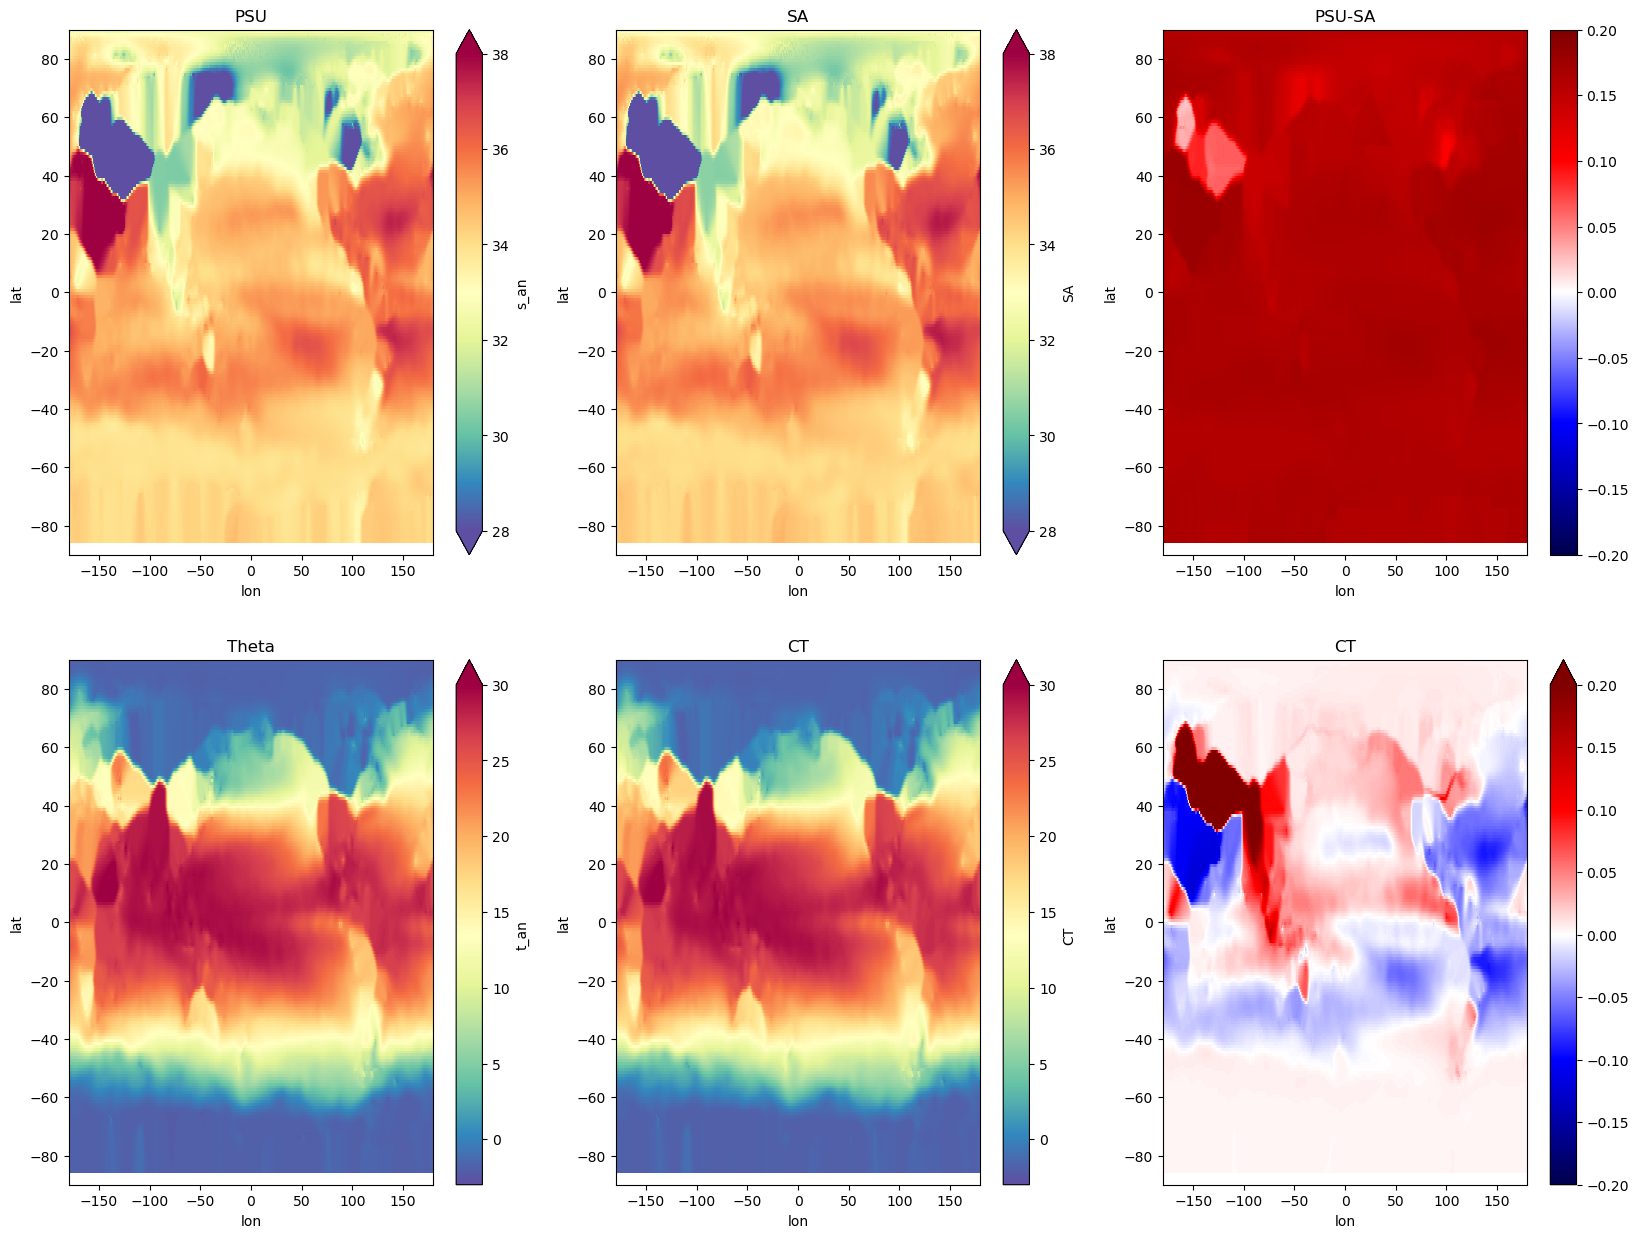

In [20]:
# Control 2D the final result
it=5 ; iz=10 

plt.figure(figsize=(20,15))
plt.subplot(231)
ds_inS['s_an'].isel(time_counter=it,z=iz).plot(vmin=28.,vmax=38.,cmap='Spectral_r',x='lon',y='lat')
plt.title('PSU')

plt.subplot(232)
ds_inS['SA'].isel(time_counter=it,z=iz).plot(vmin=28.,vmax=38.,cmap='Spectral_r',x='lon',y='lat')
#ds_SA.isel(time_counter=it,z=iz).plot(vmin=28.,vmax=38.,cmap='Spectral_r',x='lon',y='lat')
plt.title('SA')

plt.subplot(233)
#(ds_SA.isel(time_counter=it,z=iz)-ds_inS['s_an'].isel(time_counter=it,z=iz)).plot(vmin=-.2,vmax=.2,cmap='seismic')
(ds_inS['SA'].isel(time_counter=it,z=iz)-ds_inS['s_an'].isel(time_counter=it,z=iz)).plot(vmin=-.2,vmax=.2,cmap='seismic',x='lon',y='lat')
plt.title('PSU-SA')

plt.subplot(234)
ds_inT['t_an'].isel(time_counter=it,z=iz).plot(vmin=-3.,vmax=30.,cmap='Spectral_r',x='lon',y='lat')
plt.title('Theta')

plt.subplot(235)
ds_inT['CT'].isel(time_counter=it,z=iz).plot(vmin=-3.,vmax=30.,cmap='Spectral_r',x='lon',y='lat')
#ds_CT.isel(time_counter=it,z=iz).plot(vmin=-3.,vmax=30.,cmap='Spectral_r',x='lon',y='lat')
plt.title('CT')

plt.subplot(236)
(ds_inT['CT'].isel(time_counter=it,z=iz)-ds_inT['t_an'].isel(time_counter=it,z=iz)).plot(vmin=-.2,vmax=.2,cmap='seismic',x='lon',y='lat')
plt.title('CT')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


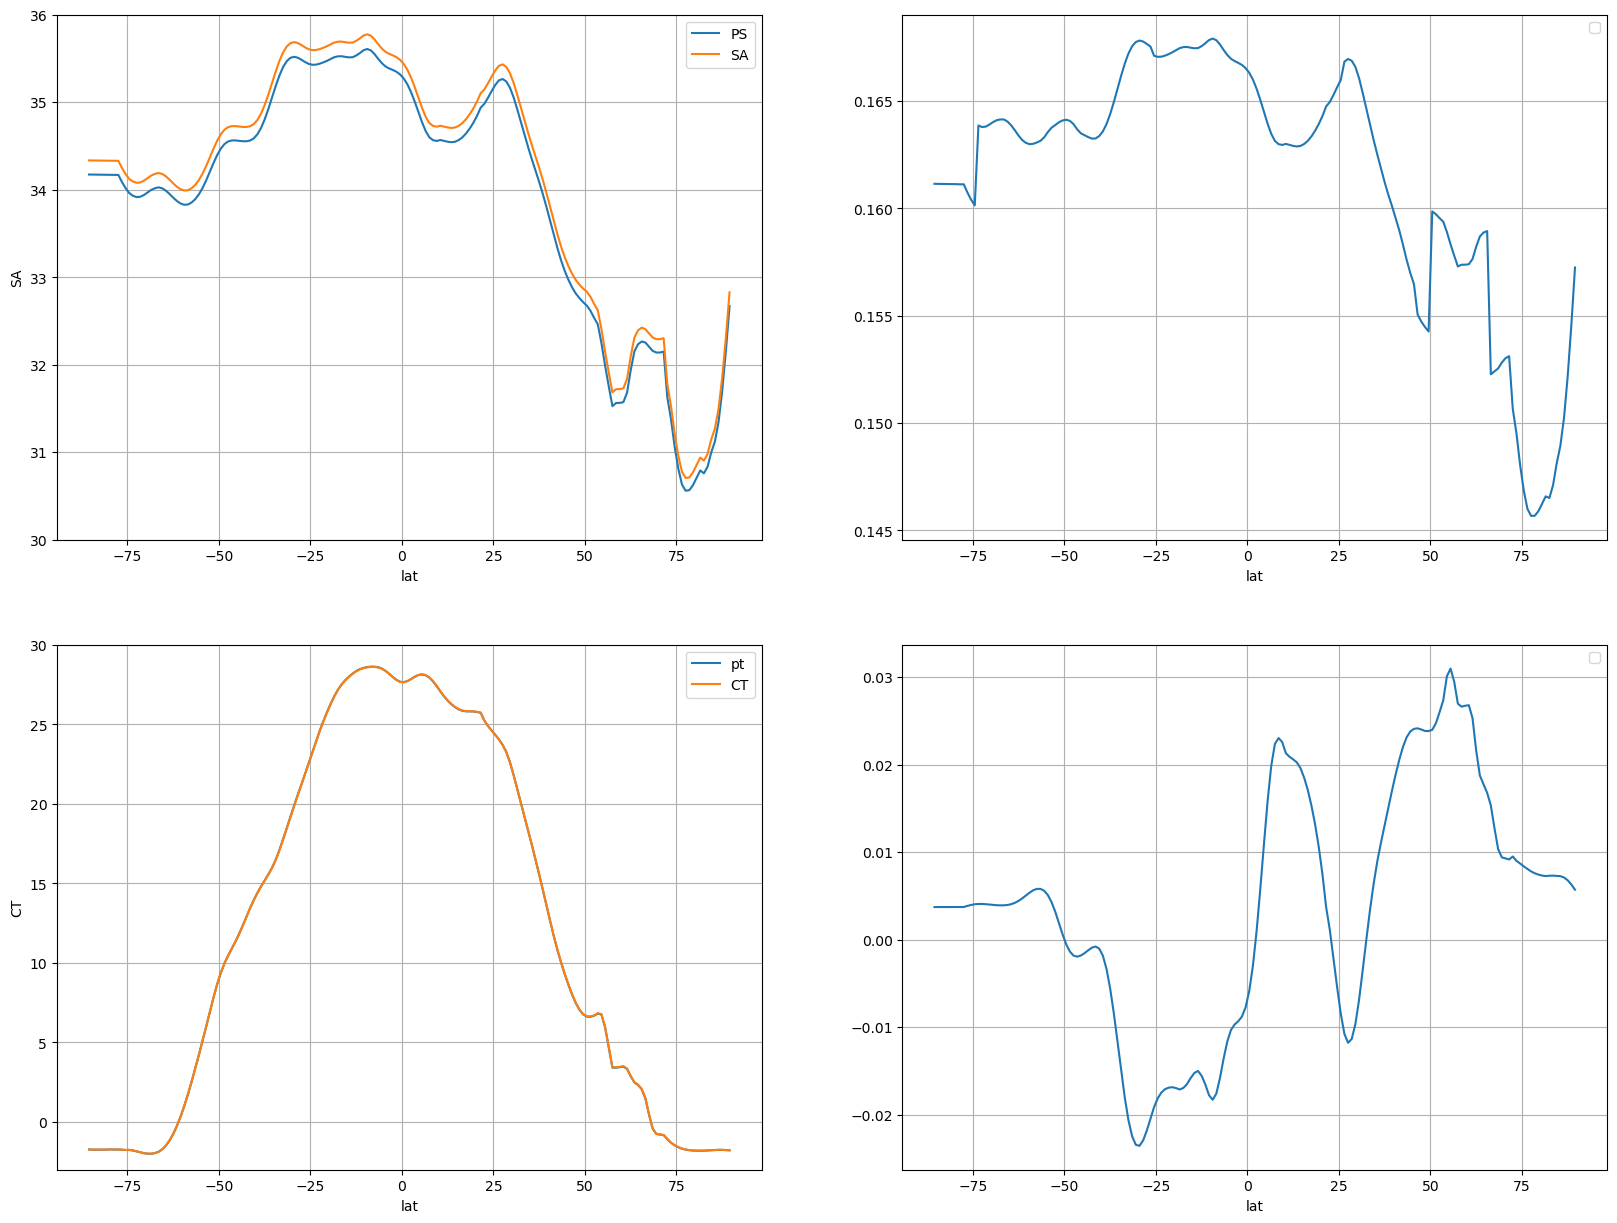

In [21]:
# Control the final result along a given longitude
it=5 ; iz=10 ; ilon=200

plt.figure(figsize=(20,15))
plt.subplot(221)
ds_inS['s_an'].isel(time_counter=it,z=iz,lon0=ilon).plot(label='PS',x='lat')
ds_inS['SA'].isel(time_counter=it,z=iz,lon0=ilon).plot(label='SA',x='lat')
#ds_SA.isel(time_counter=it,z=iz,lon0=ilon).plot(label='SA')
#plt.xlim([0,180])
plt.ylim([30,36])
plt.grid(True)
plt.legend()

plt.subplot(222)
(ds_inS['SA'].isel(time_counter=it,z=iz,lon0=ilon)-ds_inS['s_an'].isel(time_counter=it,z=iz,lon0=ilon)).plot(x='lat')
#plt.xlim([0,180])
#plt.ylim([30,36])
plt.grid(True)
plt.legend()

plt.subplot(223)
ds_inT['t_an'].isel(time_counter=it,z=iz,lon0=ilon).plot(label='pt',x='lat')
ds_inT['CT'].isel(time_counter=it,z=iz,lon0=ilon).plot(label='CT',x='lat')
#plt.xlim([0,180])
plt.ylim([-3.,30])
plt.grid(True)
plt.legend()

plt.subplot(224)
(ds_inT['CT'].isel(time_counter=it,z=iz,lon0=ilon)-ds_inT['t_an'].isel(time_counter=it,z=iz,lon0=ilon)).plot(x='lat')
#plt.xlim([0,180])
#plt.ylim([-3.,30])
plt.grid(True)
plt.legend()


In [22]:
ds_inT

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon      (lat0, lon0) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    t_an     (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
    CT       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
Attributes:
    History:  Temperature has been vertically smoothed at the most 5 times wi...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


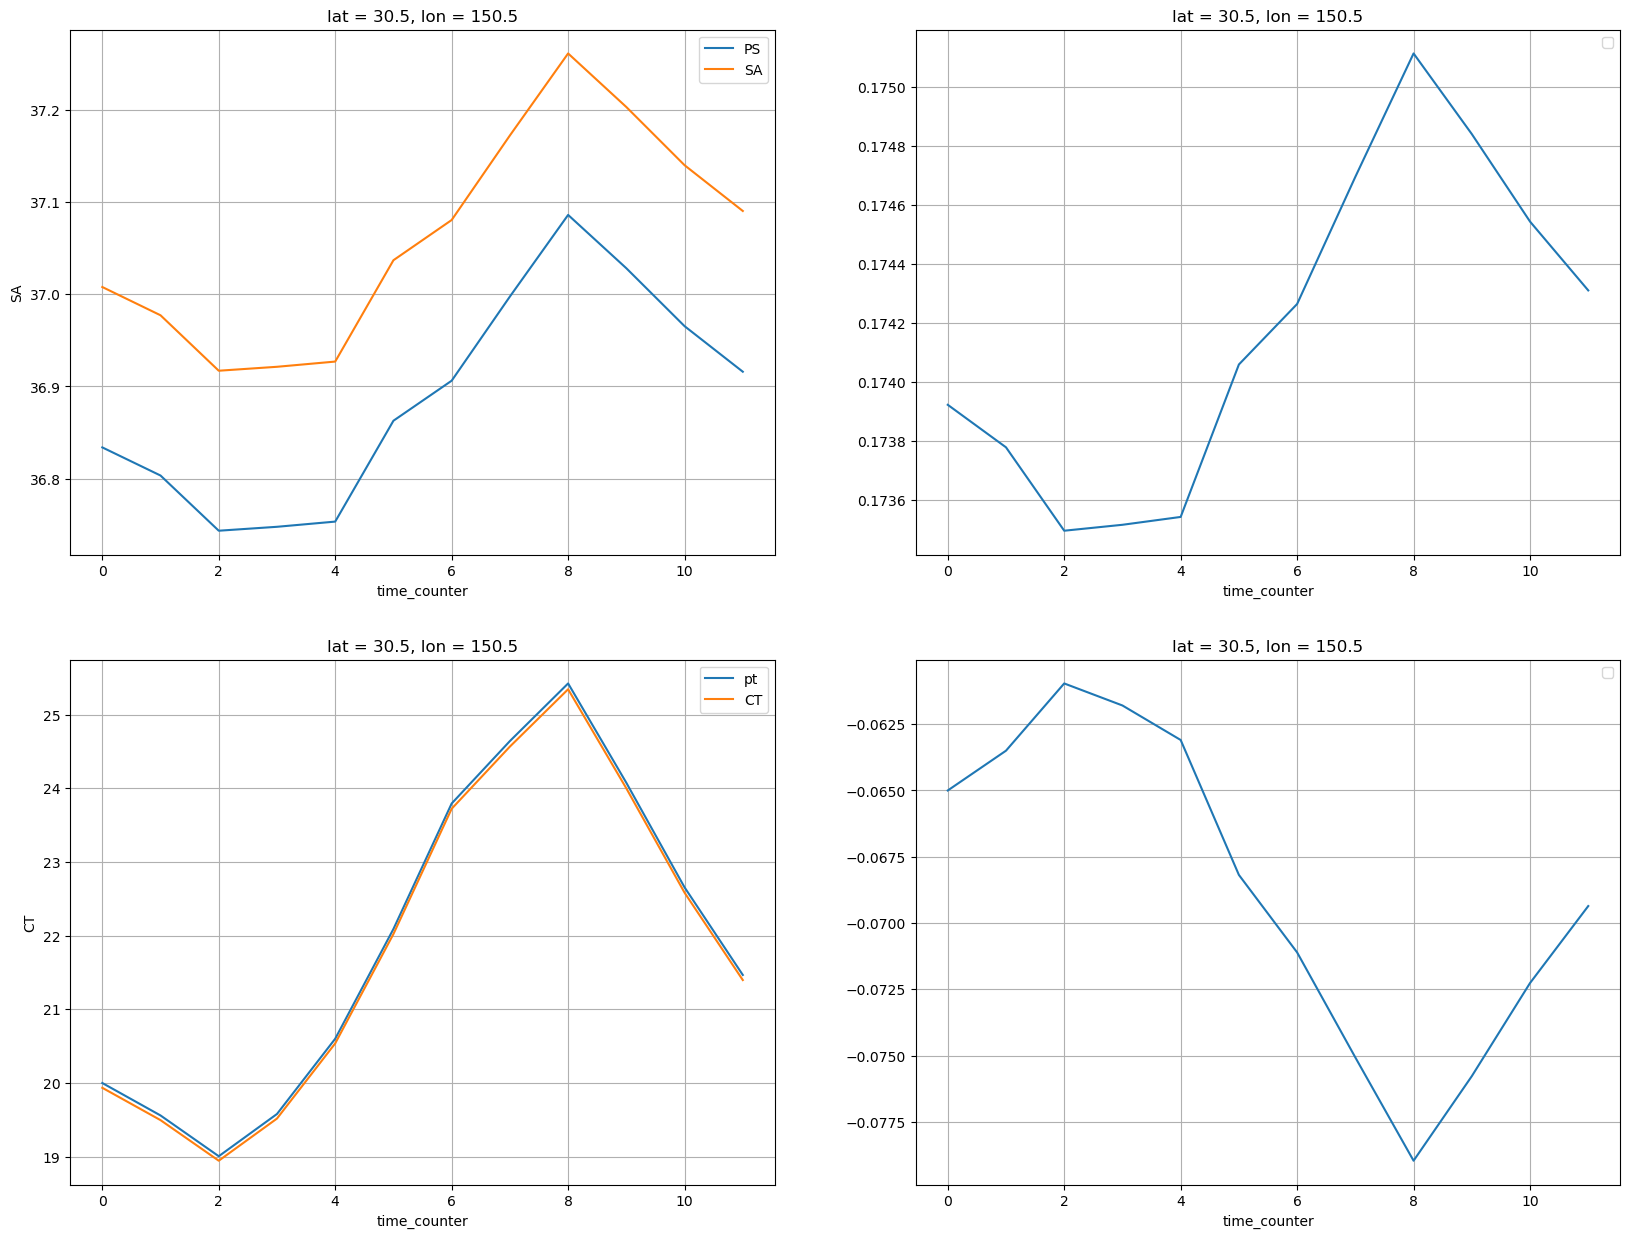

In [23]:
# Control the seasonal cycle 
ilon=330 ; ilat=120 ; iz=0 ;

plt.figure(figsize=(20,15))
plt.subplot(221)
ds_inS['s_an'].isel(z=iz,lon0=ilon,lat0=ilat).plot(label='PS',x='time_counter')
ds_inS['SA'].isel(z=iz,lon0=ilon,lat0=ilat).plot(label='SA',x='time_counter')
#plt.xlim([0,180])
#plt.ylim([30,36])
plt.grid(True)
plt.legend()

plt.subplot(222)
(ds_inS['SA'].isel(z=iz,lon0=ilon,lat0=ilat)-ds_inS['s_an'].isel(z=iz,lon0=ilon,lat0=ilat)).plot(x='time_counter')
#plt.xlim([0,180])
#plt.ylim([30,36])
plt.grid(True)
plt.legend()

plt.subplot(223)
ds_inT['t_an'].isel(z=iz,lon0=ilon,lat0=ilat).plot(label='pt',x='time_counter')
ds_inT['CT'].isel(z=iz,lon0=ilon,lat0=ilat).plot(label='CT',x='time_counter')
#plt.xlim([0,180])
#plt.ylim([-3.,30])
plt.grid(True)
plt.legend()

plt.subplot(224)
(ds_inT['CT'].isel(z=iz,lon0=ilon,lat0=ilat)-ds_inT['t_an'].isel(z=iz,lon0=ilon,lat0=ilat)).plot(x='time_counter')
#plt.xlim([0,180])
#plt.ylim([-3.,30])
plt.grid(True)
plt.legend()



# Output new fields 

In [27]:
INDIR="/data0/project/drakkar/CONFIGS/CREG025.L75/CREG025.L75-I/"

if False:
    ds_out=xr.Dataset()
    # Save WOA09 Absolute Salinity 
    ds_out['SA']=(('time_counter','z','lat0','lon0'),ds_inS['SA'].values)
    ds_out['lat']=(('lat0','lon0'),ds_inS['lat'].values)
    ds_out['lon']=(('lat0','lon0'),ds_inS['lon'].values)
    ds_out.to_netcdf(INDIR+'woa09_SalAbs_monthly_1deg_SA_CMA_drowned_Ex_L75_SM5.nc')

    ds_out=xr.Dataset()
    # Save WOA09 Conservative temperature
    ds_out['CT']=(('time_counter','z','lat0','lon0'),ds_inT['CT'].values)
    ds_out['lat']=(('lat0','lon0'),ds_inS['lat'].values)
    ds_out['lon']=(('lat0','lon0'),ds_inS['lon'].values)
    ds_out.to_netcdf(INDIR+'woa09_ConTem_monthly_1deg_CT_CMA_drowned_Ex_L75_SM5.nc')
